In [109]:
import itertools
import os
import os.path
from os import path
import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import wave
import librosa
import librosa.display
from scipy.io import wavfile as wav
from pydub import AudioSegment
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import auc
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from python_speech_features import mfcc
from sklearn.metrics import precision_recall_curve
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sys import executable
print(executable)
cwd = os.getcwd()
print(cwd)

/usr/local/opt/python/bin/python3.7
/Users/shirleychen/Desktop/hackathon


In [80]:
# Extract MFCC coefficents from .wav file 
# Arguments: .wav file
# Return value: 2D Array
N_MFCC = 40

def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=N_MFCC).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)
    # tempo, beats = librosa.beat.beat_track(y=X, sr=sample_rate, units = 'samples', start_bpm = 60)
    # print(tempo, beats)
    # plt.plot(stft)
    # plt.show()
    return np.hstack((mfccs,chroma,mel,contrast,tonnetz))

def get_mfcc(audioFile): 
    librosa_audio, librosa_sample_rate = librosa.load(audioFile)
    scipy_sample_rate, scipy_audio = wav.read(audioFile)
    mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = N_MFCC) 
    #print("Original sample rate: {}".forat(scipy_sample_rate))
    #print("Librosa sample rate: {}".format(librosa_sample_rate))
    #print (mfccs)
    return mfccs

def test_svm(X_test):
    clf = joblib.load('svm.pkl')
    result  = clf.predict_proba(X_test.reshape(1,-1)).reshape(-1)
    print('Probability of Normal: %4.2f%%' % result[0])
    print('Probability of Abnormal: %4.2f%%' % result[1])
    
def plot_confusion_matrix(cm, classes, output_folder = "./", normalize=True, 
                          title='Confusion matrix', cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(output_folder+'confusion_matrix.png')
    
# This function plots the precision-recall curve
def plot_precision_recall_curve(y_true, y_prob, output_folder="./"):
    # Compute Precision-Recall and plot curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob[:, 1])
    area = auc(recall, precision)
    print("Area Under Curve: %0.2f" % area)

    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AUC=%0.2f' % area)
    plt.legend(loc="lower left")
    plt.savefig(output_folder+'precision_recall_curve.png')


# Create manfifest file

In [55]:
normal_fp = cwd + "/RECORDS-normal"
abnormal_fp = cwd + "/RECORDS-abnormal"
#soundclip_folder = cwd + "/sound_5s/"
soundclip_folder = cwd + "/sound_10s/"
#soundclip_folder = cwd + "/sound_15s/"
#soundclip_folder = cwd + "/sound_c20s/"

normal_samples = pd.read_csv(normal_fp, header=None)
normal_samples.columns = ["sample_name"]
normal_samples["y"] = 0
abnormal_samples = pd.read_csv(abnormal_fp, header=None)
abnormal_samples.columns = ["sample_name"]
abnormal_samples["y"] = 1

manifest = pd.concat([normal_samples, abnormal_samples])
manifest["soundclip_fp"] = soundclip_folder + manifest["sample_name"] + "s.wav"

manifest.shape
manifest.head()


# Remove samples where filepath doesn't exists
file_exists = []
for index, row in manifest.iterrows():
    soundclip_fp = row["soundclip_fp"]
    if os.path.exists(soundclip_fp):
        file_exists.append("True")
    else:
        file_exists.append("False")
manifest["file_exists"] = file_exists
hold_df = manifest[manifest.file_exists=="True"]
manifest = hold_df

# Subsample so we have equal number of abnormal and normal
num_normal = sum(1 for i in manifest["y"] if i == 0) 
num_abnormal = sum(1 for i in manifest["y"] if i == 1) 
num_to_sample = min(num_normal, num_abnormal)
print("Num normal = {}".format(num_normal))
print("Num abnormal = {}".format(num_abnormal))
print("Num in each group after subsample = {}".format(num_to_sample))
grouped = manifest.groupby('y').apply(lambda x: x.sample(num_to_sample))
manifest = grouped.reset_index(drop=True)

manifest.shape
manifest.head()

example = manifest.iloc[0]["soundclip_fp"]
mel_coefs = get_mfcc(example)
N_MFCC_FEATURES = mel_coefs.shape[0] * mel_coefs.shape[1]
print("N_MFCC_FEATURES = {}".format(N_MFCC_FEATURES))

#x, fs = librosa.load(example)
#librosa.display.waveplot(x, sr=fs)

features = extract_feature(example)
N_FEATURES = len(features)
print("N_FEATURES = {}".format(N_FEATURES))

(2581, 3)

,sample_name,y,soundclip_fp
0,a0007,0,/Users/shirleychen/Desktop/hackathon/sound_10s...
1,a0009,0,/Users/shirleychen/Desktop/hackathon/sound_10s...
2,a0011,0,/Users/shirleychen/Desktop/hackathon/sound_10s...
3,a0012,0,/Users/shirleychen/Desktop/hackathon/sound_10s...
4,a0016,0,/Users/shirleychen/Desktop/hackathon/sound_10s...


Num normal = 2082
Num abnormal = 497
Num in each group after subsample = 497


(994, 4)

,sample_name,y,soundclip_fp,file_exists
0,e01504,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True
1,e01986,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True
2,e01050,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True
3,e01548,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True
4,e00668,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True


N_MFCC_FEATURES = 17240
N_FEATURES = 193


In [56]:
# Featurize
# Create X matrix where each row is a sample, each column is a feature
# y: array of labels, 0 for normal and 1 for abnormal
X = np.zeros(shape=(manifest.shape[0], N_FEATURES))
for index, row in manifest.iterrows():
    soundclip_fp = row["soundclip_fp"]
    #features = get_mfcc(soundclip_fp).flatten('F')
    features = extract_feature(soundclip_fp)
    #print(features)
    X[index,] = features
X.shape
y = manifest["y"].values

/usr/local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


(994, 193)

In [57]:
# Split data into 60% train, 40% test
X_train_indices, X_test_indices, y_train, y_test = train_test_split(np.arange(manifest.shape[0]), y, 
                                                                    train_size=.6, test_size=.4, stratify=y)
print("Num train = {}".format(len(y_train)))
print("Num test = {}".format(len(y_test)))

X_train_manifest = manifest.iloc[X_train_indices,]
X_train = X[X_train_indices,:]

X_test_manifest = manifest.iloc[X_test_indices,]
X_test = X[X_test_indices,:]

Counter(X_train_manifest.y)
Counter(X_test_manifest.y)

Num train = 596
Num test = 398


Counter({1: 298, 0: 298})

Counter({0: 199, 1: 199})

# Train/Test

In [81]:
def report_results(X, y, manifest, clf):
    manifest = manifest.copy()
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)
    prob_normal = [i[0] for i in y_prob]
    prob_abnormal = [i[1] for i in y_prob]

    manifest["y_pred"] = y_pred
    manifest["prob_normal"] = prob_normal
    manifest["prob_abnormal"] = prob_abnormal
    manifest["pred_correct"] = manifest["y"] == manifest["y_pred"]

    accuracy = clf.score(X, y)
    print("Accuracy = {}".format(accuracy))
    
    num_normal = sum(1 for i in y if i == 0) 
    num_abnormal = sum(1 for i in y if i == 1) 
    
    num_pred_normal = sum(1 for i in y_pred if i == 0) 
    num_pred_abnormal = sum(1 for i in y_pred if i == 1) 
    
    #print("Predicted {} out of {} normal".format(num_pred_normal, num_normal))
    #print("Predicted {} out of {} abnormal".format(num_pred_abnormal, num_abnormal))

    cm = confusion_matrix(y, y_pred)
    print("Confusion matrix")
    print(cm)
    plot_confusion_matrix(cm, ["normal", "abnormal"], normalize=False)
    plt.show()
    plot_precision_recall_curve(y, y_prob)
    plt.show()
    
    #disp = sklearn.metrics.plot_precision_recall_curve(clf, X_test, y_test)
    #plt.show()
    return manifest, cm


In [122]:
#clf = svm.SVC(probability = True,kernel ='poly', degree=3, class_weight="balanced")
#clf = svm.SVC(probability = True,kernel ='rbf', class_weight="balanced")
clf = LogisticRegression(class_weight="balanced")
clf = clf.fit(X_train, y_train)

print("Train performance")
results_df, cm = report_results(X_train, y_train, X_train_manifest, clf)
results_df.head()
plt.clf() 

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train performance
Accuracy = 0.9194630872483222
Confusion matrix
[[271  27]
 [ 21 277]]
Area Under Curve: 0.95


,sample_name,y,soundclip_fp,file_exists,y_pred,prob_normal,prob_abnormal,pred_correct
742,a0284,1,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.686501,0.313499,False
36,e01965,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,1,0.354840,0.645160,False
759,a0262,1,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,1,0.095817,0.904183,True
508,a0167,1,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.521974,0.478026,False
359,e00991,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.975627,0.024373,True


In [121]:
print("Test performance")
results_df, cm = report_results(X_test, y_test, X_test_manifest, clf)
results_df.head()

Test performance
Accuracy = 0.9095477386934674
Confusion matrix
[[182  17]
 [ 19 180]]
Area Under Curve: 0.93


,sample_name,y,soundclip_fp,file_exists,y_pred,prob_normal,prob_abnormal,pred_correct
351,e01560,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.968956,0.031044,True
122,a0027,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.640227,0.359773,True
197,e00486,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.709268,0.290732,True
130,e01525,0,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.982028,0.017972,True
829,e01978,1,/Users/shirleychen/Desktop/hackathon/sound_10s...,True,0,0.904656,0.095344,False


In [88]:
coef_df = pd.DataFrame(clf.coef_.T)
coef_df.columns = ["coef"]
coef_df = coef_df.sort_values(by="coef", ascending=False)
coef_df

,coef
24,0.222163
23,0.201465
25,0.188913
17,0.162523
18,0.152497
...,...
185,-0.153592
180,-0.161742
186,-0.163735
181,-0.168005


In [95]:
X_test.shape

(398, 193)

,PC1,PC2,y
0,-157.002169,-33.383764,0
1,137.743086,180.239856,0
2,-42.189732,59.370759,0
3,-126.504520,16.815392,0
4,-148.400746,-46.704534,1


<IPython.core.display.Javascript object>


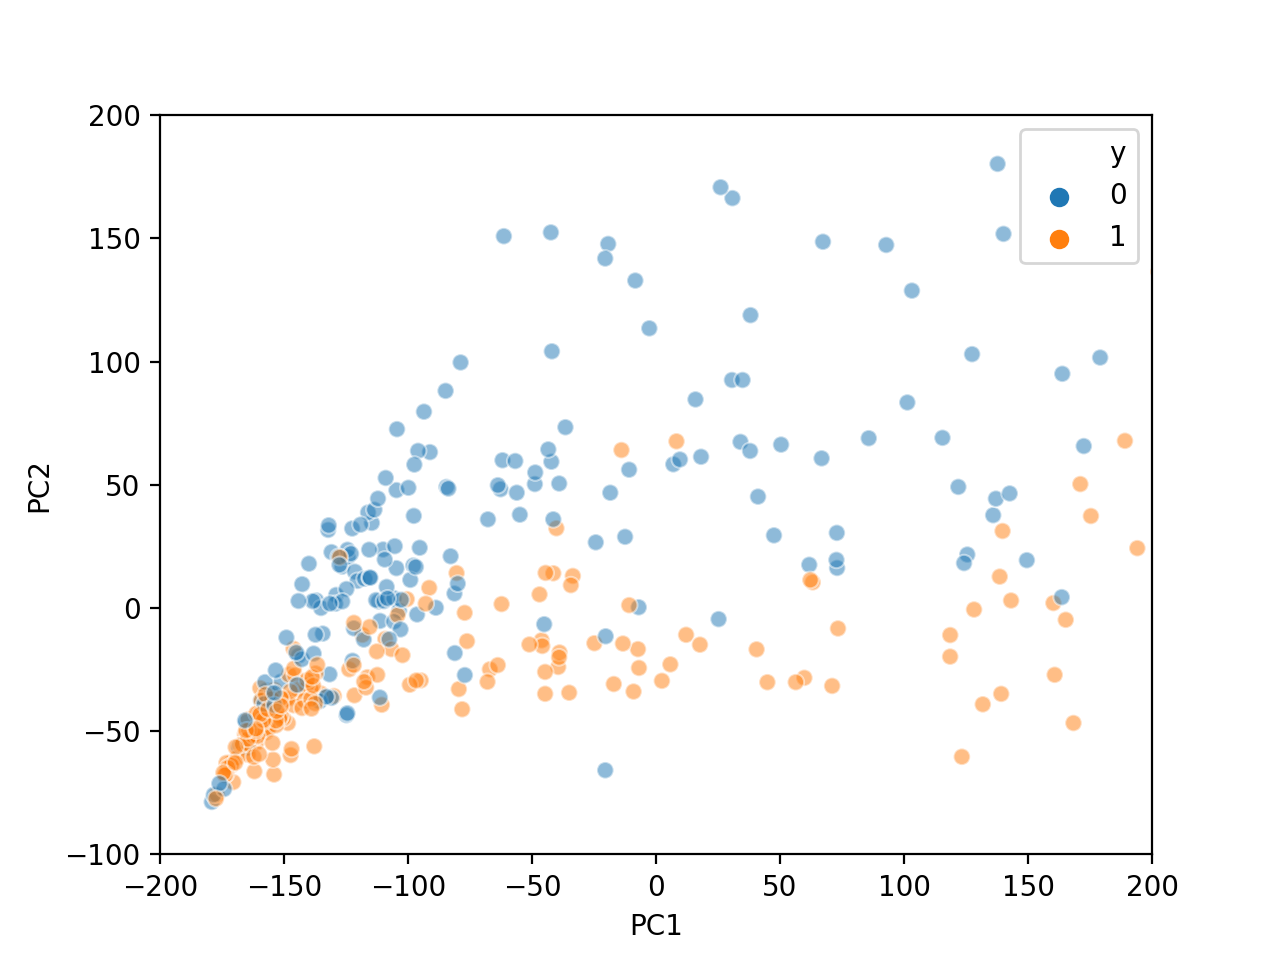

(-200, 200)

(-100, 200)

In [125]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf['y'] = y_test
principalDf.head()
sns.scatterplot(x="PC1", y="PC2", hue="y", data=principalDf, alpha=.5)
plt.xlim(-200, 200)
plt.ylim(-100, 200)
plt.show()
